In [1]:
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

In [2]:
#a handful of sites
sites = ['Barcelona','Belgrade','Berlin','Brussels','Bucharest','Budapest','Copenhagen','Dublin','Hamburg','Istanbul','Kiev','London','Madrid','Milan','Moscow','Munich','Paris','Prague','Rome','Saint Petersburg','Sofia','Stockholm','Vienna','Warsaw']
# sites = ['Barcelona','Belgrade','Berlin','Brussels','Bucharest','Budapest','Copenhagen']
latlng = ['latitude', 'longitude']
position = pd.read_csv('./data/position.csv', index_col="City")
flighttime = pd.read_csv('./data/flight_time.csv', index_col="City")
distance = pd.read_csv('./data/distance.csv', index_col="City")
position.head(5)
# print(len(sites))

,latitude,longitude
City,,
Barcelona,41.3888,2.1590
Belgrade,44.8040,20.4651
Berlin,52.5244,13.4105
Brussels,50.8505,4.3488
Bucharest,44.4323,26.1063


In [3]:
#make some positions (so we can plot this)
positions = dict( ( city, (position.loc[city, 'longitude'], position.loc[city, 'latitude']) ) for city in sites)

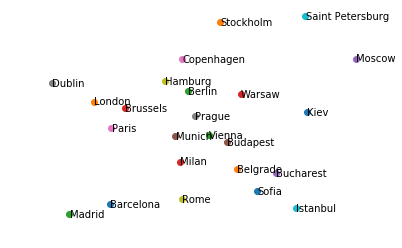

In [4]:
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.gca().axis('off');

In [5]:
# get distanc between cities
distances = dict( ((s1,s2), distance.loc[s1, s2] ) for s1 in positions for s2 in positions if s1!=s2)

## The model

With a few modifications, the original traveling salesman problem can support multiple salesman. Instead of making each facility only be visited once, the origin facility will be visited multiple times. If we have two salesman then the origin is visited exactly twice and so on.

For **K** vehicles or sales people:

### Variables:

$x_{ij}=
\begin{cases}
1: \text{the path goes from city i to j}\\
0: \text{otherwise}
\end{cases}$

### order dummy variables:

$u_i - u_j + C*x_{ij} \leq C - d_j, C = N/K$
$\begin{cases}
u_i: \text{order that site i is visited}\\
d_j: \text{the cost to visit city j}, 0 \leq u_i \leq C - d_j, \forall i \in V \setminus \{0\}
\end{cases}$

### Goal:

$min\sum_{i=0}^{n}\sum_{j\neq{i}, j=0}^{n}{c_{ij}}{x_{ij}}$
$\begin{cases}
c_{ij}: \text{distance from city i to city j}\\
x_{ij}: \text{whether there's a path between i and j}
\end{cases}$

### Constraints:

$\sum_{i\in{V}}{x_{ij} = 1}, \forall j \in V \setminus \{0\}$

$\sum_{j\in{V}}{x_{ij} = 1}, \forall i \in V \setminus \{0\}$

$\sum_{i\in{V}}{x_{i0} = K}$

$\sum_{j\in{V}}{x_{0j} = K}$

In [14]:
K = 4 #the number of sales people 

In [15]:
#create the problme
prob=LpProblem("vehicle", LpMinimize)

In [16]:
#indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x',distances, 0,1,LpBinary)
#dummy vars to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)

In [17]:
#the objective
cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

In [18]:
#constraints
for k in sites:
    cap = 1 if k != 'Berlin' else K
    #inbound connection
    prob+= lpSum([ x[(i,k)] for i in sites if (i,k) in x]) ==cap
    #outbound connection
    prob+=lpSum([ x[(k,i)] for i in sites if (k,i) in x]) ==cap
    
#subtour elimination
N=len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != 'Berlin' and j!= 'Berlin') and (i,j) in x:
            prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1

Solve it!

In [19]:
%time prob.solve()
#prob.solve(GLPK_CMD(options=['--simplex']))
print(LpStatus[prob.status])

CPU times: user 95.8 ms, sys: 31.3 ms, total: 127 ms
Wall time: 44min 58s
Optimal


In [20]:
non_zero_edges = [ e for e in x if value(x[e]) != 0 ]

def get_next_site(parent):
    '''helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0]==parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges

In [21]:
tours = get_next_site('Berlin')
tours = [ [e] for e in tours ]

for t in tours:
    while t[-1][1] !='Berlin':
        t.append(get_next_site(t[-1][1])[-1])

The optimal route:

In [22]:
for t in tours:
    print(' -> '.join([ a for a,b in t]+['Berlin']))

Berlin -> Budapest -> Bucharest -> Istanbul -> Sofia -> Belgrade -> Vienna -> Berlin
Berlin -> Hamburg -> Dublin -> London -> Paris -> Brussels -> Berlin
Berlin -> Prague -> Rome -> Barcelona -> Madrid -> Milan -> Munich -> Berlin
Berlin -> Warsaw -> Kiev -> Moscow -> Saint Petersburg -> Stockholm -> Copenhagen -> Berlin


Calculate total time:

In [23]:
totalTime = 0;
for t in tours:
    time = 0
    for i in range(0, len(t)):
        time += flighttime.loc[t[i][0], t[i][1]]
#         print(flighttime.loc[t[i][0], t[i][1]])
#     print(time)
    if time > totalTime:
        totalTime = time
print(totalTime)

1988


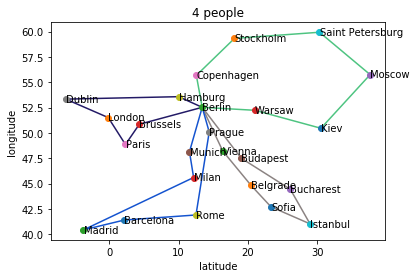

In [24]:
#draw the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t,c in zip(tours,colors):
    for a,b in t:
        p1,p2 = positions[a], positions[b]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

#draw the map again
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.title('%d '%K + 'people' if K > 1 else 'person')
plt.xlabel('latitude')
plt.ylabel('longitude')
# plt.gca().axis('off')
plt.show()

In [25]:
print('Longest time spent:', totalTime, '(min)')
print('Total distance:', value(prob.objective), '(km)')

Longest time spent: 1988 (min)
Total distance: 15425.02 (km)
